In [159]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from category_encoders.target_encoder import TargetEncoder

import os

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

df = pd.read_csv(csv_fn)

In [239]:
def fill_nans(dataframe):
    df = dataframe.copy()
    
    df['card_type'] = df['card_type'].fillna(3)
    return df


def fix_phone_col(df):
    pass



def encode_categorical(df_train, df_val, target):
    train = df_train.copy()
    val = df_val.copy()
    
    train['gender'] = train.gender.map(lambda x: 0 if x == 'm' else 1)
    val['gender'] = train.gender.map(lambda x: 0 if x == 'm' else 1)
    
    cols = ['os_family', 'lt_user', 'country_code', 
            'phone', 'period', 'discount', 'currency_id', 'cpa', 'psp',
            'last_response_code', 'bank', 'card_type', 'card_country_code']
    
    for col in cols: 
        train[col] = train[col].map(lambda x: col + str(x))
        val[col] = val[col].map(lambda x: col + str(x))
        
    
    
    encoder = TargetEncoder()
    train = encoder.fit_transform(train, target)
    val = encoder.transform(val)
    return train, val

def train_test_split_timeseries(df):
    x_train = df[df['current_dt'].isin(datetimes[:-1])]
    x_val = df[df['current_dt'].isin(datetimes[-1:])]

    x_train, y_train,  = x_train.drop(['is_success', 'current_dt'], axis=1), x_train['is_success']
    x_val, y_val = x_val.drop(['is_success', 'current_dt'], axis=1), x_val['is_success']
    
    return x_train, x_val, y_train, y_val


def col_log(train, val):
    x_train, x_val = train.copy(), val.copy()
    
    cols = ['gross', 'root_gross', 'not_root_gross']
    for col in cols:
        mu, sigma = x_train[col].mean(), x_train[col].std()
        x_train[col] = x_train[col].clip(mu - 3*sigma, mu+3*sigma)
        x_val[col] = x_val[col].clip(mu - 3*sigma, mu+3*sigma)

        x_train[col] = np.log(x_train[col] + 0.0001)
        x_val[col] = np.log(x_val[col] + 0.0001)
        
    return x_train, x_val



In [234]:
counts_df = df.groupby(['phone', 'is_success'])['user_id'].count().unstack()
percentes = counts_df.T.div(counts_df.T.sum()).T
percentes = percentes.fillna(0)
percentes

is_success,0,1
phone,,
1.0,0.666667,0.333333
2.0,0.000000,1.000000
3.0,1.000000,0.000000
4.0,0.833333,0.166667
7.0,1.000000,0.000000
...,...,...
5695.0,0.000000,1.000000
5696.0,1.000000,0.000000
5697.0,1.000000,0.000000


In [240]:
cols_to_drop = ['Unnamed: 0', 'current_dt', 'root_order_id', 'lt_user', 'old_model_probability',]
cols_remain = df.drop(cols_to_drop, axis=1).columns

print('Duplicated rows: ', df.duplicated(cols_remain).sum())
df_dup = df[~df.duplicated(cols_remain)]

cols_to_drop = ['Unnamed: 0', 'user_id', 'scheduled_dt',
                'root_order_id', 'old_model_probability',]

df_drop = df_dup.drop(cols_to_drop, axis=1)
x_train, x_val, y_train, y_val = train_test_split(df_drop.drop(['is_success', 'current_dt'], axis=1),
                                                  df_drop['is_success'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# x_train, x_val, y_train, y_val = train_test_split_timeseries(df_drop)

x_train_fill = fill_nans(x_train)
x_val_fill = fill_nans(x_val)
x_train_enc, x_val_enc = encode_categorical(x_train_fill, x_val_fill, y_train)

# x_train_enc, x_val_enc = col_log(x_train_enc, x_val_enc)

Duplicated rows:  38658


C:\Users\sqrte\.conda\envs\genesis\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [237]:
model = XGBClassifier(eval_metric='logloss',
                      use_label_encoder=False)
model.fit(x_train_enc, y_train)
predictions = model.predict(x_val_enc)

In [238]:
f1 = f1_score(predictions, y_val)
roc_auc = roc_auc_score(predictions, y_val)

print('\n----------------------------')
print('Model f1: ', f1)
print('Model roc_auc: ', roc_auc)


----------------------------
Model f1:  0.3012649207197577
Model roc_auc:  0.6655916889507526


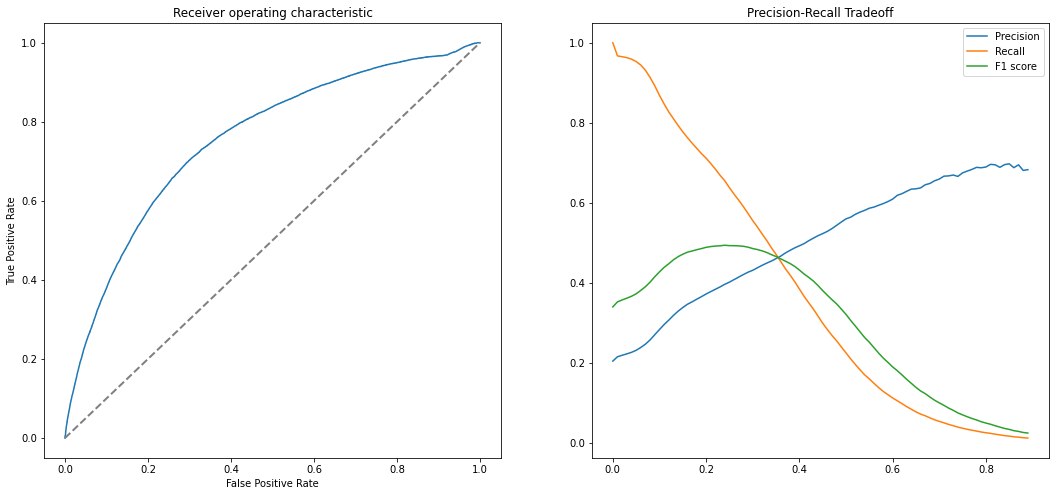

In [216]:
predictions_prob = model.predict_proba(x_val_enc)

fpr, tpr, _ = roc_curve(y_val, predictions_prob[:,1])

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
ax[0].plot(fpr, tpr)
ax[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
ax[0].set_title('Receiver operating characteristic')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

precisions = []
recalls = []
f1s = []

x = np.arange(0, 0.9, 0.01)
for threshold in x:
    model_predictions = np.array(predictions_prob > threshold, dtype='int8')
    precision = precision_score(y_val, model_predictions[:,1])
    recall = recall_score(y_val, model_predictions[:,1])
    f1 = f1_score(y_val, model_predictions[:, 1])
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

ax[1].set_title('Precision-Recall Tradeoff')
ax[1].plot(x, precisions, label='Precision')
ax[1].plot(x, recalls, label='Recall')
ax[1].plot(x, f1s, label='F1 score')
ax[1].legend()
plt.show()